# Vector Autoregression (VAR) models

The task is to predict the rates for all the three currencies in "Currencies.csv".

Steps 1-4 are the same as in "Forecasting with exogenous variables.ipynb" from the previous lecture.

In [1]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

# Load data

In [2]:
df = pd.read_csv("Currencies.csv")

# convert the "Date" column to the datetime type
df['Date'] = pd.to_datetime(df['Date'], format="%d%b%Y")

df.set_index("Date", inplace=True)

# Train-test split

In [3]:
from sklearn.model_selection import train_test_split

# making sure we do not shuffle the time series data!
train_set, test_set = train_test_split(df, test_size=0.2, random_state=7, shuffle=False)

train_set.columns = df.columns
test_set.columns = df.columns

print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

3190 train and 798 test instances


# Exploratory Data Analysis

<AxesSubplot: xlabel='Date'>

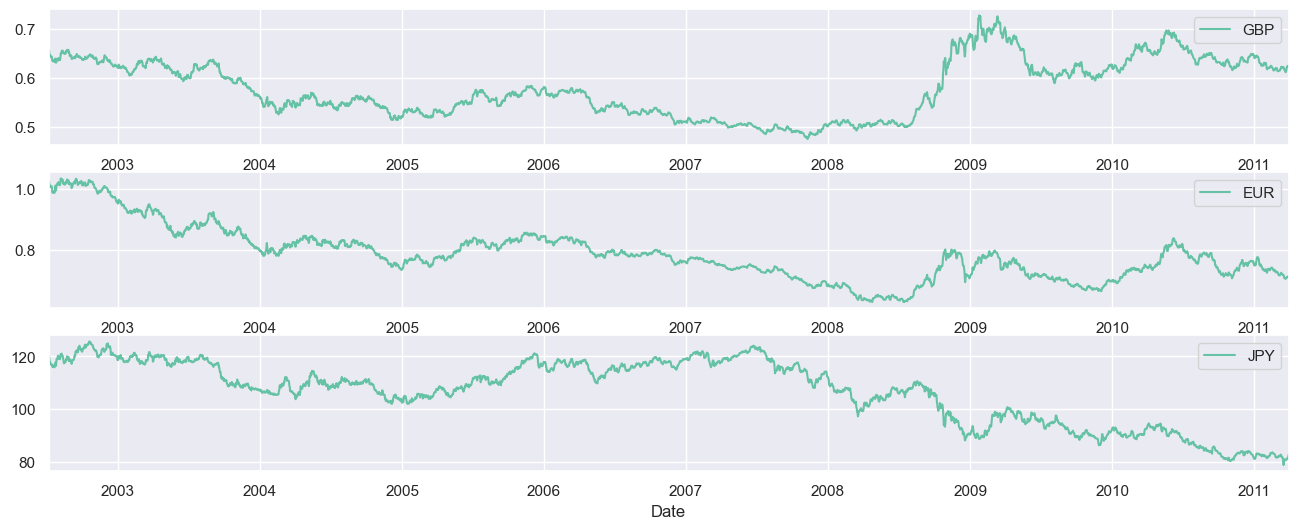

In [4]:
plt.subplot(311)
train_set['GBP'].plot(figsize=(16, 6), legend=True)
plt.subplot(312)
train_set['EUR'].plot(figsize=(16, 6), legend=True)
plt.subplot(313)
train_set['JPY'].plot(figsize=(16, 6), legend=True)

# Data transformation

From "Forecasting with exogenous variables.ipynb" we know that all the three variables are not stationary and can be stationarized via the first differencing.

In [5]:
# difference all the columns and drop the missing values resulting from differencing
train_diff = train_set.diff().dropna()

# do the same with the test data
test_diff = test_set.diff().dropna()

# Build a VAR model

## Determine the order of the model

In [6]:
from statsmodels.tsa.vector_ar.var_model import VAR

We can use the `select_order` method to determine the best order: taking the maximum number of lags, the method will build VAR models for each number of lags and output the values of IC for each.

The optimal number of lags are indicated with an asterisk in each column.

In [7]:
results = VAR(train_diff).select_order(maxlags=12)
results.summary()

,AIC,BIC,FPE,HQIC
0,-24.86,-24.86,1.591e-11,-24.86
1,-24.97,-24.95*,1.431e-11,-24.96*
2,-24.98*,-24.94,1.423e-11*,-24.96
3,-24.97,-24.92,1.425e-11,-24.95
4,-24.97,-24.90,1.425e-11,-24.95
5,-24.97,-24.88,1.426e-11,-24.94
6,-24.97,-24.86,1.429e-11,-24.93
7,-24.97,-24.85,1.427e-11,-24.93
8,-24.97,-24.83,1.425e-11,-24.92
9,-24.97,-24.81,1.429e-11,-24.91


Two information criteria suggest 2 lags and two other ones suggest 3 lags. Let's go for the lag of 2.

## Train a VAR

In [8]:
model = VAR(train_diff).fit(2)

The fitted model is a VARResults object (detailed documentation about it can be looked up [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html#statsmodels.tsa.vector_ar.var_model.VARResults)). We can print a summary of the model:

In [9]:
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Mar, 2023
Time:                     19:14:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -24.9366
Nobs:                     3187.00    HQIC:                  -24.9623
Log likelihood:           26254.7    FPE:                1.42168e-11
AIC:                     -24.9766    Det(Omega_mle):     1.41236e-11
--------------------------------------------------------------------
Results for equation EUR
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.000084         0.000069           -1.218           0.223
L1.EUR         0.130175         0.025592            5.087           0.000
L1.GBP        -0.041452         0.034365           -1.206           0.228
L1.JPY        -0

The tables show signficant variables for each equation in the system. For EUR, the only significant variable is its own lag 1. For GBP, all of the variables at both lags are significant, except JPY at lag 2. For JPY, only its own lag 1 is signficant.

# Evaluate the model on test data

The forecast for the first time period after the training data can be generated as follows:

In [13]:
model.forecast(model.endog, steps=1)

array([[-0.00027198, -0.00078613,  0.11129393]])

We will use the same process to evaluate the model on test data as with the ARIMA model: the forecasts will be done only one step ahead, then the true value of the test instance will be added to the training data and the model is re-trained. 

In [15]:
# buffers keeping training + previously seen test data
history = train_diff.values
predictions = []

# for each test observation
for i, test_obs in enumerate(test_diff.values):
    
    # build a model using the current buffers
    model = VAR(history).fit(2)
        
    # forecast the value for the test instance, supplying corresponding exogenous variables 
    yhat = model.forecast(model.endog, steps=1)
    
    # remember the forecasted value
    predictions.append(yhat[0])
    
    # update the buffers for the endogenous and exogenous variables
    history = np.append(history, test_obs.reshape(1, -1), axis=0)
    
    #print('predicted=%s, expected=%s' % (yhat, test_obs))

predictions = pd.DataFrame(predictions, columns=test_diff.columns, index=test_diff.index)

In [16]:
predictions

,EUR,GBP,JPY
Date,,,
2011-04-02,-0.000272,-0.000786,0.111294
2011-04-03,-0.000286,0.000102,0.092685
2011-04-04,-0.000425,-0.000626,0.055989
2011-04-05,-0.000059,0.000025,-0.002075
2011-04-06,0.000039,-0.000326,-0.000381
...,...,...,...
2013-06-02,-0.000101,-0.000200,-0.028569
2013-06-03,0.000115,0.000355,-0.050426
2013-06-04,-0.000070,-0.000021,-0.005909


## Plot the predictions

We will plot the first 200 predictions and the corresponding true values.

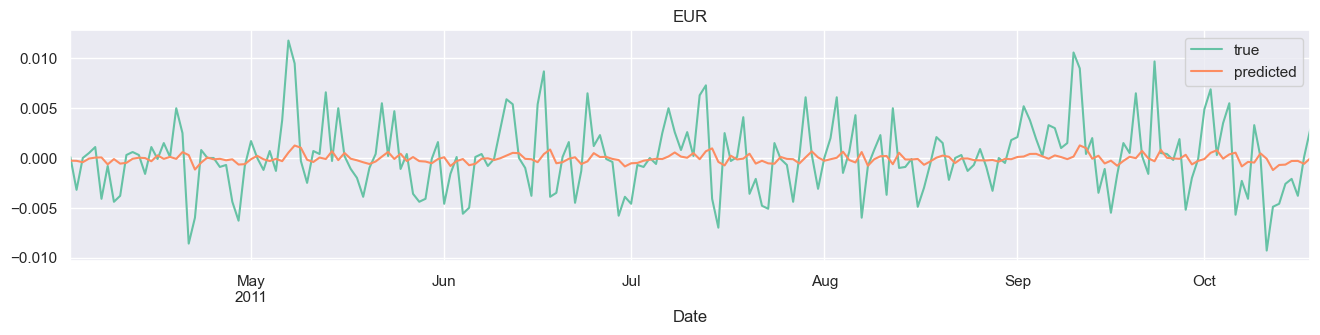

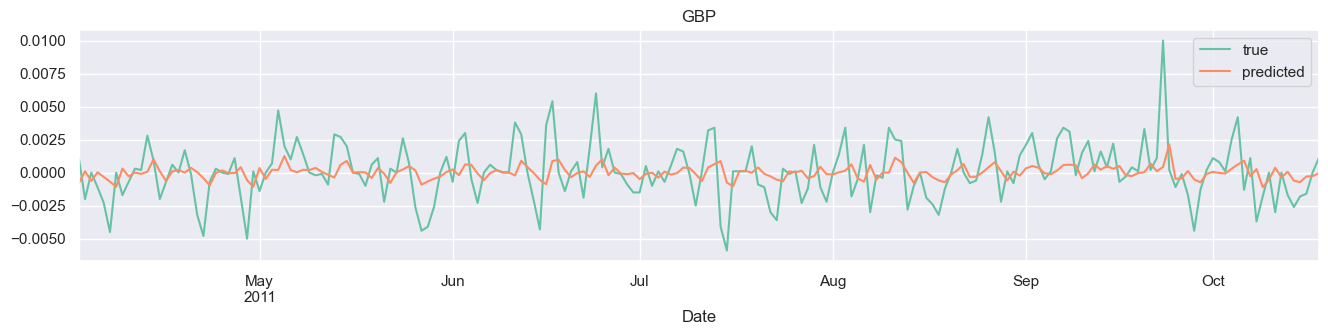

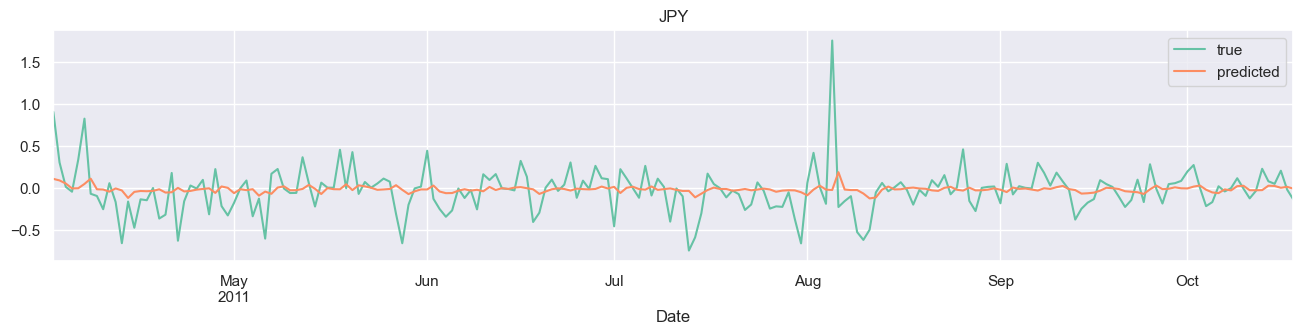

In [17]:
for x in ["EUR", "GBP", "JPY"]:
    pd.DataFrame({"true": test_diff[x][:200], 
                  "predicted": predictions[x][:200]}).plot(figsize=(16, 3), title=x)

## Calculate accuracy measures

In [18]:
for x in ["EUR", "GBP", "JPY"]:
    rmse = np.sqrt(mean_squared_error(test_diff[x], predictions[x]))
    print(x)
    print(f"RMSE: {rmse}")
    mda = get_mda(test_diff[x], predictions[x])
    print(f"MDA: {mda}")
    print()

EUR
RMSE: 0.002965578956541991
MDA: 0.39321608040201006

GBP
RMSE: 0.0018350406844789737
MDA: 0.44221105527638194

JPY
RMSE: 0.32423408419163596
MDA: 0.4321608040201005



It may be interesting to compare these with the accuracy scores we obtained with ARIMA and ARIMAX (see the notebooks from the previous week, "Forecasting with endogenous variables.ipynb" and "Forecasting with exogenous variables.ipynb"):
    
GBP with ARIMA:
* RMSE: 0.002038
* MDA: 0.457286

EUR with ARIMAX:
* RMSE: 0.003508
* MDA: 0.407035

I.e. compared both to ARIMA and ARIMAX, the VAR model produced worse RMSE results, but better MDA results.

# Granger causality

We go over the pairs of the currencies and measure the Granger causality in both directions in each pair.

Detailed documentation on the implementation of the Granger causality test in statsmodels can be found [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.test_causality.html).

In [19]:
# the data input into VAR was in three columns: EUR, GBP, JPY
train_diff.head(3)

,EUR,GBP,JPY
Date,,,
2002-07-08,-0.0013,-0.0005,-0.17
2002-07-09,-0.0165,-0.0096,-1.64
2002-07-10,-0.0031,-0.0017,-0.34


In [20]:
for i, c1 in enumerate(train_diff.columns):
    for j, c2 in enumerate(train_diff.columns):
        if i >= j:
            continue
        print(f"Does {c1} Granger-cause {c2}?")
        print(model.test_causality(j, i).summary())
        print(f"Does {c2} Granger-cause {c1}?")
        print(model.test_causality(i, j).summary())

Does EUR Granger-cause GBP?
Granger causality F-test. H_0: y1 does not Granger-cause y2. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         8.371          2.996   0.000 (2, 11928)
------------------------------------------------
Does GBP Granger-cause EUR?
Granger causality F-test. H_0: y2 does not Granger-cause y1. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.175          2.996   0.309 (2, 11928)
------------------------------------------------
Does EUR Granger-cause JPY?
Granger causality F-test. H_0: y1 does not Granger-cause y3. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
        0.3428          2.996   0.710 (2, 11928)
-------------------------------

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2022). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
